<span style='font-size: 50px'>Projeto Final</span>

**Disciplina:** Projeto Nível I em Controle e Processamento de Sinais I

**Alunos:** Bruno Mingoti e Ramiro Gurgel

**Professor:** Joceli Mayer

# Importações

In [1]:
import numpy as np 
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from skimage.segmentation import clear_border
from skimage import measure, color
import pandas as pd

# Avaliação das imagens H&E Stain

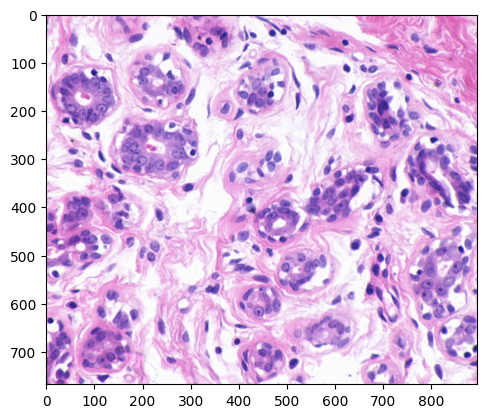

In [2]:
img = cv2.imread("images/sample1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversão do sistema RGB para HSV
plt.imshow(img)
plt.show()

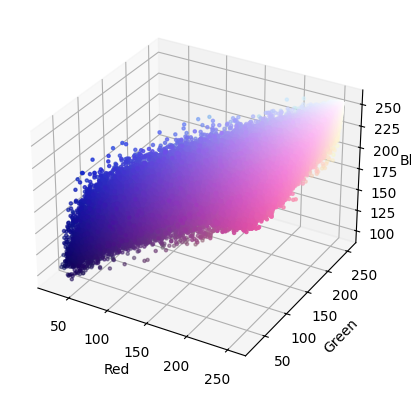

In [3]:
# Analisar gráfico 3D de cada um dos canais do RGB

r, g, b = cv2.split(img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

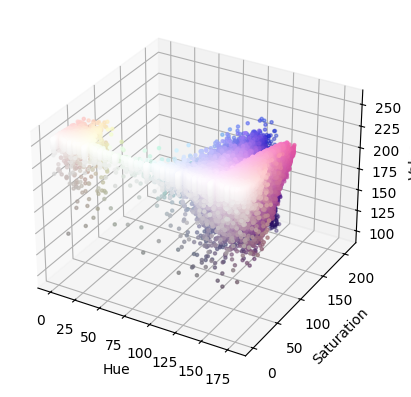

In [4]:
# Analisar gráfico 3D de cada um dos canais do HSV

hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

Como as imagens microscópicas de H&E Stain seguem o mesmo padrão de cores pela utilização da coloração hematoxilina-eosina, decidiu-se converter as imagens de entrada para HSV. Essa técnica irá compor o primeiro método aplicado para a segmentação dos núcleos, seguida pela aplicação do watershed, segundo recomendado pela documentação do OpenCV para a resolução desse tipo de problema.

## Obtenção do lower e upper values para o HSV

In [5]:
def nothing(x):
    pass

# Carrega a imagem
image = cv2.imread("images/sample1.png")

# Cria a janela
cv2.namedWindow('image')

# Hue assume valores entre 0 e 179 no OpenCV
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Valor inicial dos HSV Max trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Inicializa valores HSV min/max
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # A cada iteração do loop, pega os valores atuais dos trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Atribui os valores mínimos e máximos HSV para exibir na imagem
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Converte para HSV e aplica o threshold de cores
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper) # verifica se os lementos o array estão entre os elementos de dois outros arrays
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print os valores de HSV
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Mostra a imagem resultante
    cv2.imshow('image', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break


cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/neo/Documentos/bmt/graduacao/codes/projeto_controle_2/venv/lib/python3.10/site-packages/cv2/qt/plugins"


(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)


# Segmentação com HSV + Watershed

In [6]:
# Leitura de várias imagens H&E Stain
path = "./images"
all_images = []
for image in os.listdir(path):
   img = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(), 'images', image)), cv2.COLOR_BGR2RGB)
   all_images.append(img)

In [7]:
def segment_cell(image, hMin=0, sMin=0, vMin=0, hMax=138, sMax=255, vMax=216):
    ''' 
        Realiza uma segmentação inicial da imagem, considerando apenas a cor azul, obtida através do espaço de cores HSV.

        param:
            image: imagem a ser segmentada
        return:
            mask: imagem binária com a região de interesse
    '''

    # Converte a imagem para HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_color = (hMin, sMin, vMin)
    upper_color = (hMax, sMax, vMax)

    # Aplica a máscara considerando os valores lower e upper
    mask = cv2.inRange(hsv_image, lower_color, upper_color)

    # Aplica o filtro de suavização
    blur = cv2.GaussianBlur(mask, (3, 3), 0)
    return blur

In [8]:
results = [segment_cell(sample) for sample in all_images]

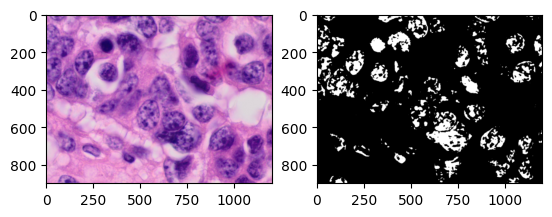

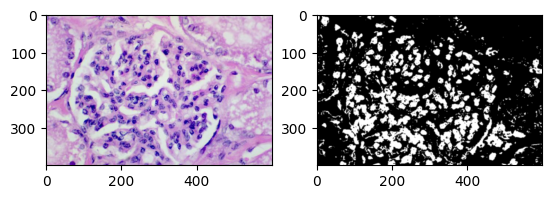

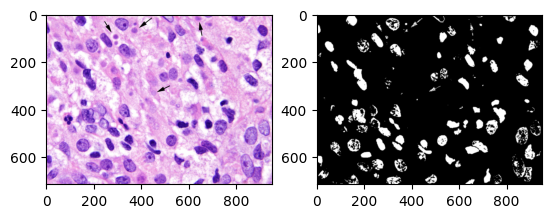

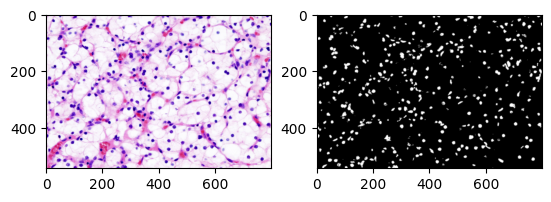

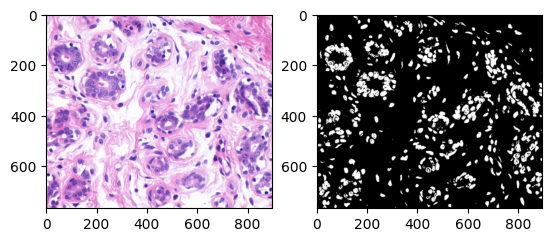

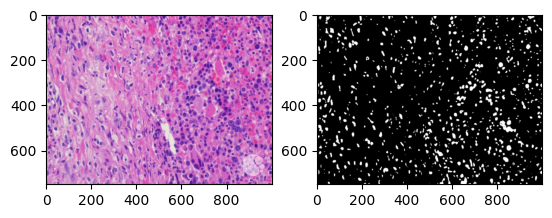

In [9]:
for i in range(len(results)):
    plt.subplot(1, 2, 1)
    plt.imshow(all_images[i])
    plt.subplot(1, 2, 2)
    plt.imshow(results[i], cmap="gray")
    plt.show()

In [10]:
test_img = results[4] # alterar para qual imagem deseja-se analisar

In [11]:
# Inicia o processo de segmntação

ret, thresh = cv2.threshold(test_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
opening = clear_border(opening) # Remove os objetos que tocam as bordas da imagem. A contagem não deve ser realizada nesse casos

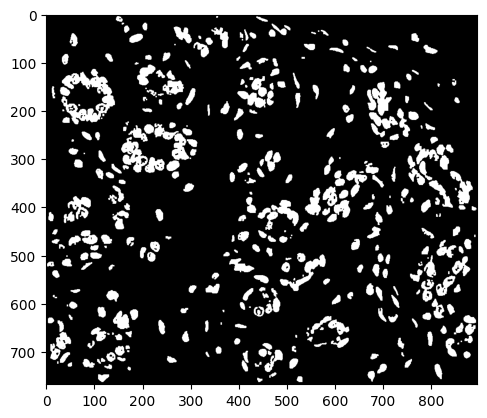

In [12]:
plt.imshow(opening, cmap="gray")
plt.show()

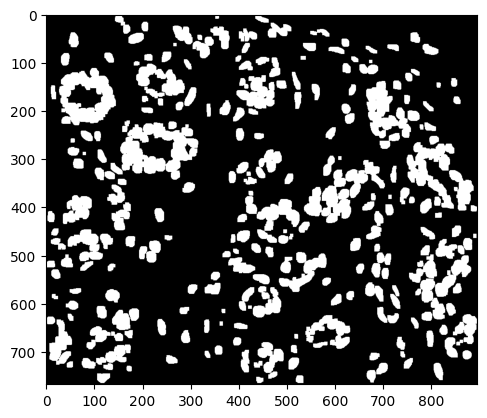

In [13]:
sure_bg = cv2.dilate(opening, kernel, iterations=2) # sure_bg significa que temos certeza que o background é de fato background
plt.imshow(sure_bg, cmap="gray")
plt.show()

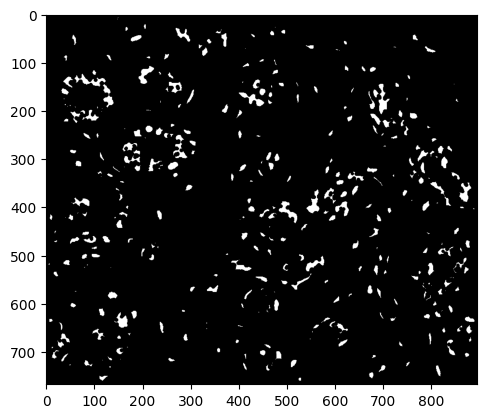

In [14]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3) # calcula a distância aproximada de cada pixel da imagem binária até o pixel zer mais próximo
ret2, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0) # 0.3
plt.imshow(sure_fg, cmap="gray")
plt.show()

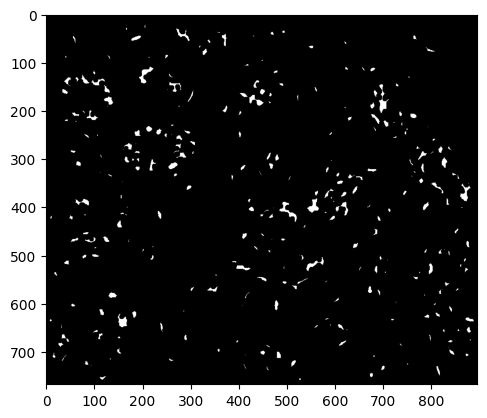

In [15]:
sure_fg = cv2.erode(sure_fg, kernel, iterations=1) # sure_fg significa que é certeza que o pixel pertence ao foreground
plt.imshow(sure_fg, cmap="gray")

## Watershed

O watershed é um algoritmo baseado em marcador, onde devemos especificar quais pontos do vale devem ser mesclados e quais não devem. Para tal, devemos rotular a região que temos certeza de ser o primeiro plano ou o objeto de estudo (foreground), a região que temos certeza de ser o fundo (background) e a região unknown, na qual não temos certeza de nada, devemos rotular como zero. Esse será o que chamamos de marcador. A partir daqui, aplica-se o watershed.

In [16]:
original_image = all_images[4].copy() # alterar ínidice da imagem para qual deseja-se analisar

objects number is: 317


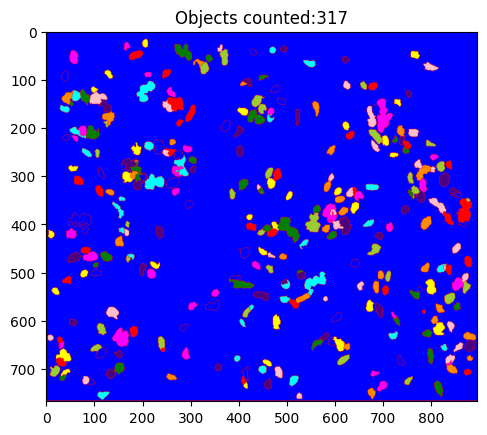

In [17]:
sure_fg = np.uint8(sure_fg) # converte para inteiro de 8 bits sem sinal
unknown = cv2.subtract(sure_bg, sure_fg) # pixels desconhecidos
ret3, hsv_markers = cv2.connectedComponents(sure_fg) # descritor de componentes conectados (contagem de objetos)
hsv_markers = hsv_markers + 10
hsv_markers[unknown==255] = 0
hsv_markers = cv2.watershed(original_image, hsv_markers)
original_image[hsv_markers == -1] = [255,0,0]
original_image2 = color.label2rgb(hsv_markers, bg_label=0)
plt.imshow(original_image2)
plt.title('Objects counted:'+ str(ret3-1))
plt.imshow(original_image2)
print('objects number is:', ret3-1)
plt.show()

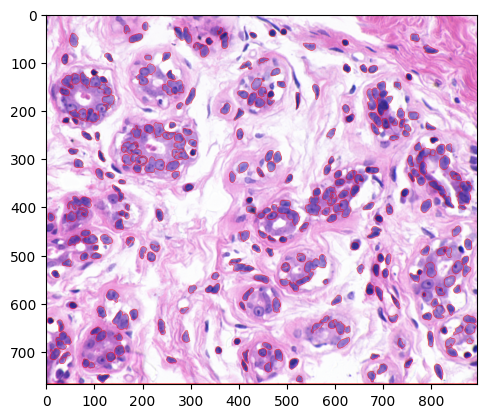

In [18]:
plt.imshow(original_image)
plt.show()

# Segmentação com normalização + OD space

Aqui buscou-se aplicar as mesmas técnicas acima com relação ao watershed, porém contendo a normalização explicitada e forncecida pelo artigo "A method for normalizing histology slides for quantitative analysis", na qual utilizamos o sistema de densidade óptica como ponto de partida, ao invés do HSV. Os seguntes passos foram seguidos:

<img src="./doc_images/OD_space.png" alt="Getting started" width=400 />

In [19]:
img = cv2.imread("images/sample1.png", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [20]:
Io = 240
alpha = 1
beta = 0.15

HERef = np.array([[0.5626, 0.2159],
                [0.7201, 0.8012],
                [0.4062, 0.5581]])

maxCRef = np.array([1.9705, 1.0308])

h, w, c = img.shape
img = img.reshape((-1,3))
OD = -np.log10((img.astype(np.float)+1)/Io)

/tmp/ipykernel_18074/853480146.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  OD = -np.log10((img.astype(np.float)+1)/Io)


In [21]:
ODhat = OD[~np.any(OD < beta, axis=1)]
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
That = ODhat.dot(eigvecs[:,1:3])
phi = np.arctan2(That[:,1],That[:,0])
minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

In [22]:
if vMin[0] > vMax[0]:
    HE = np.array((vMin[:,0], vMax[:,0])).T
else:
    HE = np.array((vMax[:,0], vMin[:,0])).T

Y = np.reshape(OD, (-1, 3)).T
C = np.linalg.lstsq(HE,Y, rcond=None)[0]
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])

In [23]:
Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

In [24]:
H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

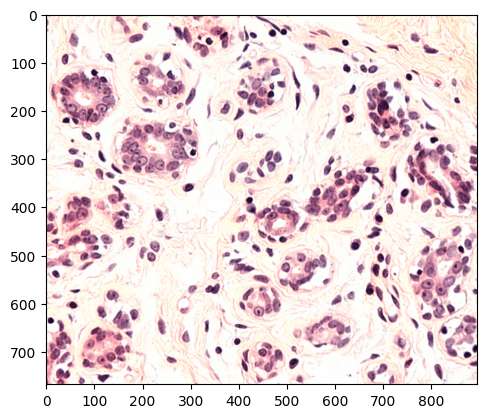

In [25]:
plt.imshow(Inorm) # imagem após a normalização
plt.show()

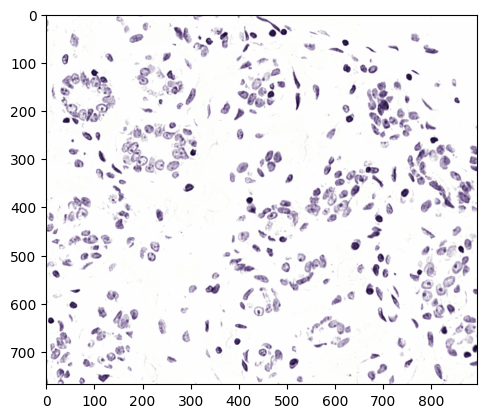

In [26]:
plt.imshow(H) # imagem apenas com a componenete H (hematoxilina)
plt.show()

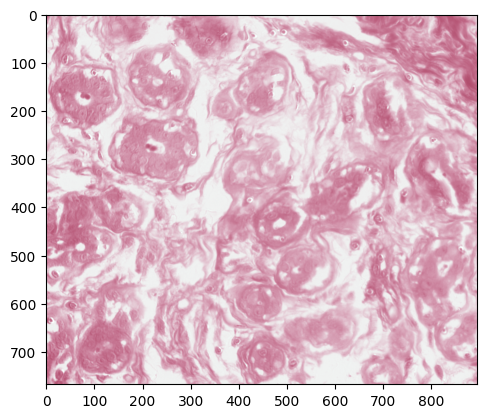

In [27]:
plt.imshow(E) # imagem apenas com a componenete E (eosina)
plt.show()

## Segmentação dos núcleos

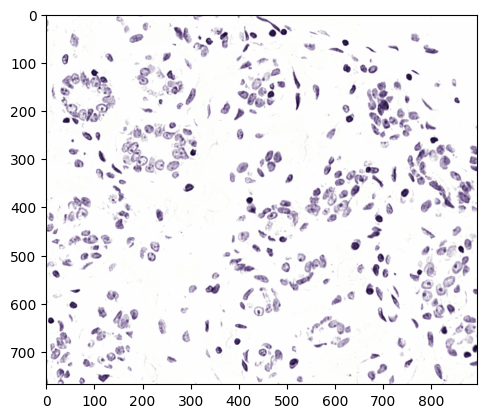

In [28]:
# Trabalhando com imagens H
img = H.copy()
# img = np.array(img, dtype=np.uint8)

# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cells=img[:,:,0] # Equivalente a uma imagem em escala de cinza, retornará com apenas um canal
# plt.imshow(cells, cmap='gray')
plt.imshow(img)

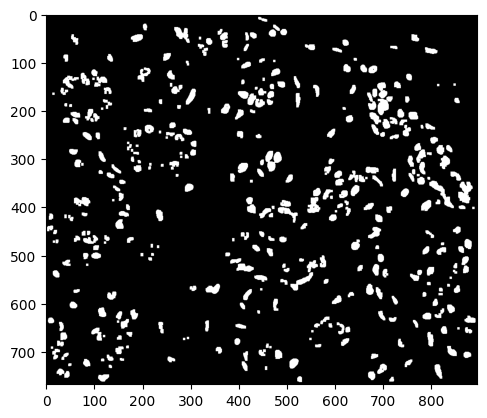

In [29]:
# Aplicação das técnicas necessárias para o uso do watershed

ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=2)
opening = clear_border(opening)
plt.imshow(opening, cmap='gray')


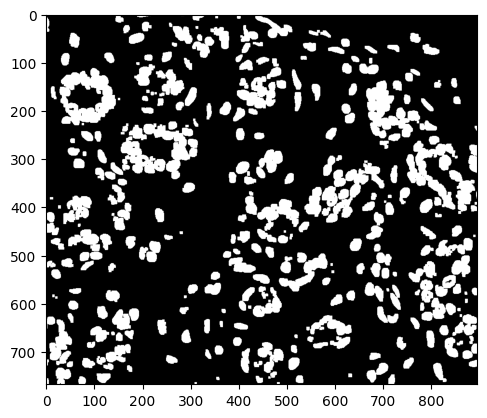

In [30]:
sure_bg = cv2.dilate(thresh, kernel, iterations=2)
# sure_bg = cv2.bitwise_not(sure_bg)
plt.imshow(sure_bg, cmap='gray')

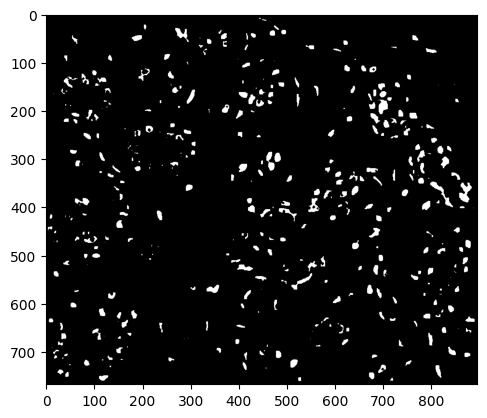

In [31]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret2, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
plt.imshow(sure_fg, cmap='gray')

In [32]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret3, OD_markers = cv2.connectedComponents(sure_fg)
OD_markers = OD_markers+10
OD_markers[unknown==255] = 0
img = np.uint8(img)
OD_markers = cv2.watershed(img, OD_markers)
img[OD_markers == -1] = [255,0,0]  
img2 = color.label2rgb(OD_markers, bg_label=0)

objects number is: 400


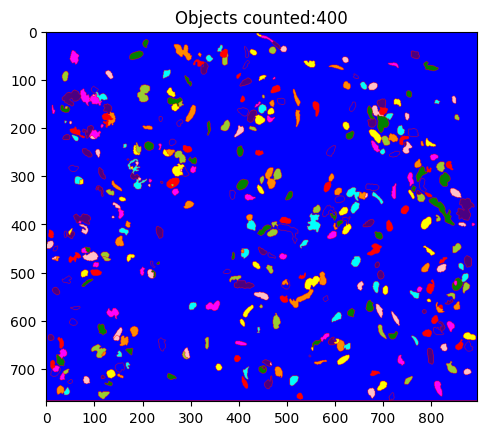

In [33]:
plt.imshow(img2)
plt.title('Objects counted:'+ str(ret3-1))
plt.imshow(img2)
print('objects number is:', ret3-1)
plt.show()

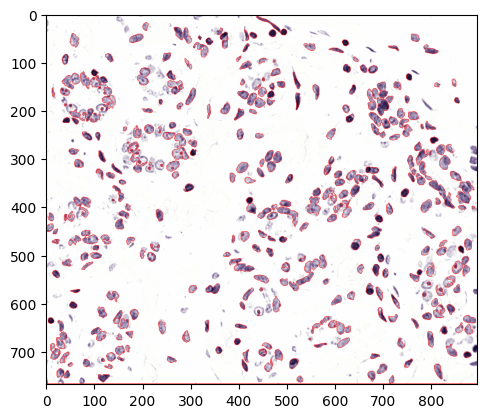

In [34]:
plt.imshow(img)

# Cálculos

In [35]:
# Caracterísiticas a serem analisadas

propList = ['Area',
            'equivalent_diameter',
            'orientation',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MaxIntensity',
            'MeanIntensity',
            'Solidity']

pixels_to_um = 0.457 # 1 pixel = 500 nm, indica a escala da imagem proporcional em micrômetros

## HSV + Watershed

In [36]:
# adicionar para o hsv o mesmo código abaixo
hsv_regions = measure.regionprops(hsv_markers, intensity_image=cells)

In [37]:
# Criação das características que serão analisadas
data_list_hsv = []

for region_props in hsv_regions:
    data = {}
    for prop in propList:
        if prop == 'Area':
            data[prop] = region_props[prop] * pixels_to_um**2
        elif prop == 'orientation':
            data[prop] = region_props[prop] * 57.2958
        elif prop.find('Intensity') < 0:
            data[prop] = region_props[prop] * pixels_to_um
        else:
            data[prop] = region_props[prop]
    data_list_hsv.append(data)

# Criação do DataFrame a partir da lista
df_hsv = pd.concat([pd.DataFrame([data]) for data in data_list_hsv], ignore_index=True)

# Agora o dataframe contém todas as características extraídas de cada núcleo segmentado


In [38]:
df_hsv[1:].describe()

Area  equivalent_diameter  orientation  MajorAxisLength  \
count  317.000000           317.000000   317.000000       317.000000   
mean    48.405532             7.457810    -0.827673        10.057585   
std     34.446747             2.455999    48.033318         4.111237   
min      0.208849             0.515669   -87.958536         0.000000   
25%     27.776917             5.946988   -42.562824         7.585963   
50%     39.890159             7.126691     1.553340         9.463755   
75%     58.060022             8.597925    38.071252        11.428885   
max    251.454196            17.893055    89.420652        32.554696   

       MinorAxisLength   Perimeter  MinIntensity  MaxIntensity  MeanIntensity  \
count       317.000000  317.000000    317.000000    317.000000     317.000000   
mean          6.097257   28.507035     78.851735    253.466877     154.737182   
std           2.052650   12.410246     35.623028     13.186215      38.394916   
min           0.000000    0.000000      9.000000    110.000000      39.783784   
25%           4.979500   21.308730     59.000000    255.000000     138.696296   
50%           5.840690   26.808969     78.000000    255.000000     160.344023   
75%           7.043131   32.498503    100.000000    255.000000     181.676667   
max          14.160389   94.439874    255.000000    255.000000     255.000000   

         Solidity  
count  317.000000  
mean     0.399021  
std      0.036730  
min      0.223837  
25%      0.378545  
50%      0.408699  
75%      0.426017  
max      0.457000

In [39]:
df2_hsv = df_hsv.drop(df_hsv[df_hsv['Area'] > 20000].index) # alterado para melhores visualizações

array([[<Axes: title={'center': 'Area'}>]], dtype=object)

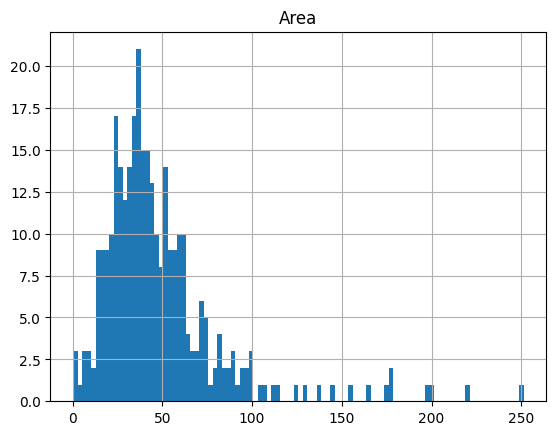

In [40]:
df2_hsv.hist(column='Area', bins=100)

In [41]:
# as etapas abaixo foram performada com o intuito de remover outliers

# Calcular a mediana, 1º quartil e 3º quartil
median = df2_hsv['Area'].median()
q1 = df2_hsv['Area'].quantile(0.25)
q3 = df2_hsv['Area'].quantile(0.75)

# Calcular os limites superior e inferior - avaliar desvio padrão
upper_limit = median + 2 * (q3 - q1)
lower_limit = median - 2 * (q3 - q1)

# Filtrar e manter apenas as linhas dentro do intervalo
df_filtered_hsv = df2_hsv[(df2_hsv['Area'] >= lower_limit) & (df2_hsv['Area'] <= upper_limit)]

In [42]:
df_filtered_hsv

Area  equivalent_diameter  orientation  MajorAxisLength  \
1    31.536199             6.336650    -0.704661         7.824342   
2    25.688427             5.719049   -12.531205         7.226463   
4    23.808786             5.505841    25.922978         5.532962   
5     0.208849             0.515669    45.000016         0.000000   
6    28.612313             6.035754   -19.476840         6.159565   
..         ...                  ...          ...              ...   
313  72.679452             9.619686    18.836494        14.452111   
314  41.769800             7.292665     1.803021         9.182598   
315  45.946780             7.648611    16.581081         9.390368   
316  53.256495             8.234578   -75.673218        10.997628   
317  22.346843             5.334125    10.548005         5.578407   

     MinorAxisLength  Perimeter  MinIntensity  MaxIntensity  MeanIntensity  \
1           5.181726  20.551547         117.0         255.0     188.649007   
2           5.162632  21.955025         154.0         240.0     197.772358   
4           5.485480  17.163252          16.0         255.0      48.219298   
5           0.000000   0.000000         255.0         255.0     255.000000   
6           5.935450  18.723547          21.0         125.0      43.211679   
..               ...        ...           ...           ...            ...   
313         6.486635  35.729981          73.0         255.0     151.902299   
314         6.197479  25.989616         115.0         255.0     197.530000   
315         6.520091  27.817616          81.0         255.0     151.154545   
316         6.722406  29.488799          39.0         255.0     110.560784   
317         5.264146  17.430956         115.0         255.0     168.065421   

     Solidity  
1    0.436753  
2    0.379804  
4    0.427033  
5    0.457000  
6    0.437825  
..        ...  
313  0.432163  
314  0.402643  
315  0.408699  
316  0.431611  
317  0.432735  

[300 rows x 10 columns]

## Normalização + OD + Watershed

In [43]:
regions = measure.regionprops(OD_markers, intensity_image=cells)

In [44]:
# Criação das características que serão analisadas
data_list_OD = []

for region_props in regions:
    data = {}
    for prop in propList:
        if prop == 'Area':
            data[prop] = region_props[prop] * pixels_to_um**2
        elif prop == 'orientation':
            data[prop] = region_props[prop] * 57.2958
        elif prop.find('Intensity') < 0:
            data[prop] = region_props[prop] * pixels_to_um
        else:
            data[prop] = region_props[prop]
    data_list_OD.append(data)

# Criação do DataFrame a partir da lista
df_OD = pd.concat([pd.DataFrame([data]) for data in data_list_OD], ignore_index=True)

# Agora o dataframe contém todas as características extraídas de cada núcleo segmentado


In [45]:
df_OD[1:].describe()

Area  equivalent_diameter  orientation  MajorAxisLength  \
count  400.000000           400.000000   400.000000       400.000000   
mean    34.239227             6.212710     2.530926         8.984010   
std     24.516158             2.238189    47.159644         3.967707   
min      1.253094             1.263127   -89.874520         1.583094   
25%     18.326500             4.830516   -37.283741         6.601743   
50%     30.491954             6.230856     2.127771         8.591774   
75%     44.745898             7.547992    40.917462        10.914979   
max    188.381798            15.487258    90.000032        36.466737   

       MinorAxisLength   Perimeter  MinIntensity  MaxIntensity  MeanIntensity  \
count       400.000000  400.000000    400.000000    400.000000     400.000000   
mean          4.911137   24.066408     79.612500    198.892500     136.695453   
std           1.905496   11.225977     33.163563     32.107213      33.295574   
min           0.861727    2.931296      9.000000     86.000000      37.067961   
25%           3.493762   17.679058     59.750000    180.000000     117.750000   
50%           5.004249   23.649173     79.500000    204.000000     142.700690   
75%           6.027273   28.574799    103.000000    220.000000     161.283971   
max          12.823888   91.227421    155.000000    254.000000     193.404762   

         Solidity  
count  400.000000  
mean     0.392077  
std      0.044385  
min      0.184592  
25%      0.369603  
50%      0.406350  
75%      0.425051  
max      0.457000

In [46]:
df2_OD = df_OD.drop(df_OD[df_OD['Area'] > 20000].index) # alterado para melhores visualizações

array([[<Axes: title={'center': 'Area'}>]], dtype=object)

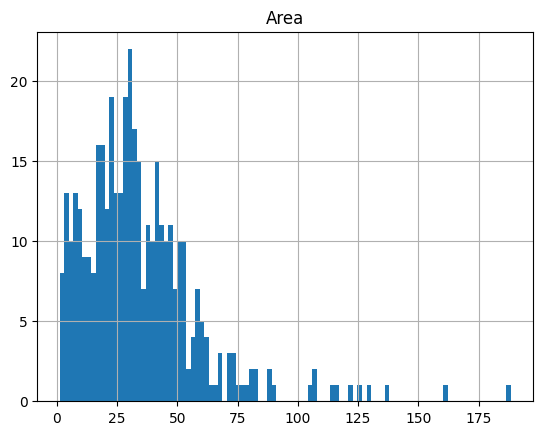

In [47]:
df2_OD.hist(column='Area', bins=100)

In [48]:
# as etapas abaixo foram performada com o intuito de remover outliers

# Calcular a mediana, 1º quartil e 3º quartil
median = df2_OD['Area'].median()
q1 = df2_OD['Area'].quantile(0.25)
q3 = df2_OD['Area'].quantile(0.75)

# Calcular os limites superior e inferior - avaliar desvio padrão
upper_limit = median + 2 * (q3 - q1)
lower_limit = median - 2 * (q3 - q1)

# Filtrar e manter apenas as linhas dentro do intervalo
df_filtered_OD = df2_OD[(df2_OD['Area'] >= lower_limit) & (df2_OD['Area'] <= upper_limit)]

In [49]:
df_filtered_OD

Area  equivalent_diameter  orientation  MajorAxisLength  \
1     6.474319             2.871125    59.892250         5.296415   
2    17.961014             4.782120    65.630796        13.974901   
3    25.061880             5.648874   -14.114032         7.443384   
4    20.258353             5.078753    47.715939        10.248943   
6    17.543316             4.726187   -28.828870         7.172742   
..         ...                  ...          ...              ...   
396  24.644182             5.601602   -25.468116         6.970651   
397  42.605196             7.365231    16.383341         9.010812   
398  46.573327             7.700585   -79.050463        10.406556   
399  21.929145             5.284038    33.000682         5.722879   
400  20.049504             5.052506   -18.893255         6.876943   

     MinorAxisLength  Perimeter  MinIntensity  MaxIntensity  MeanIntensity  \
1           1.753806  11.032956          74.0         147.0     102.516129   
2           2.287844  24.429321          67.0         152.0     102.697674   
3           4.464324  19.748434         117.0         214.0     170.533333   
4           2.620070  21.373686          25.0         141.0      76.268041   
6           3.518657  18.834434          82.0         232.0     143.833333   
..               ...        ...           ...           ...            ...   
396         4.725476  19.102138          64.0         184.0     119.228814   
397         6.196134  25.454208          81.0         193.0     140.465686   
398         6.362049  28.574799          39.0         162.0      86.757848   
399         4.926385  16.516956         115.0         204.0     157.571429   
400         4.075761  19.196786         129.0         198.0     161.281250   

     Solidity  
1    0.372816  
2    0.300015  
3    0.412331  
4    0.399360  
6    0.358766  
..        ...  
396  0.414815  
397  0.427651  
398  0.431826  
399  0.436227  
400  0.384842  

[386 rows x 10 columns]

# Comentários

É possível observar um certo delta entre as contagens de cada um dos métodos, sendo algo que deve ser validado. Para tal, a equipe está mantendo contato com o Laboratório de Biologia da UFSC para obtenção dessas informações e uma eventual visita ao laboratório para conhecer mais sobre o processo.

Além disso, segundo os dados obtidos através da função regionProps, há contagens que são realizadas equivocadamente, em decorrência de possíveis erros na segmentação, ocorrendo contagens de áreas muito pequenas. Nesse sentido, buscou-se implementar a técnica que utiliza a mediana dos valores das áreas com uma margem de 2 vezes o desvio padrão dos dados, valor que se mostrou próxima da contagem real, segundo dados fornecido do laboratório.

A técnica principal utilizada para problemas de segmentação de núcleos é o watershed, ocorrendo mais variações nas técnicas de normalização e escolha de qual sistema de cores adotar inicialmente.